# 1. Read dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
meta = pd.read_csv("../metadata.csv")
print(meta.shape)
meta.head()

C:\Users\zhipe\Anaconda3\envs\tm\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(341713, 19)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


Filter meta file by selecting only papers after 2020.

In [3]:
meta["publish_time"] = pd.to_datetime(meta["publish_time"])
meta["publish_year"] = pd.DatetimeIndex(meta['publish_time']).year
meta["publish_month"] = pd.DatetimeIndex(meta['publish_time']).month
meta = meta[meta["publish_year"] == 2020]
print(meta.shape[0], " papers are available after 2020 Jan 1.")

247255  papers are available after 2020 Jan 1.


Create dataframe with all abstracts and use it as input corpus.

In [4]:
index = []
for i in range(len(meta)):
    if type(meta.iloc[i, 8]) != float:
        index.append(i)
docs = meta.iloc[index, 8]
docs = docs.reset_index(drop= True)
print(docs.shape)
docs.head()

(163820,)


0    BACKGROUND: Dexmedetomidine has been reported ...
1    BACKGROUND: Global end-diastolic volume (GEDV)...
2    BACKGROUND: Human metapneumovirus (HMPV) is an...
3    BACKGROUND: Antimicrobial resistance (AMR) com...
4    Glycoconjugate vaccines based on bacterial cap...
Name: abstract, dtype: object

In [5]:
samp_size = 50000 #Here, the size can be changed. 
samp_docs = docs.sample(n=samp_size,random_state=100)

# 2. Preprocessing texts

Sentence level preprocess
* Lowercase + base filter
* Some basic normalization

In [6]:
import re
def preprocess_sent(rw):
    """
    Get sentence level preprocessed data from raw review texts
    :param rw: review to be processed
    :return: sentence level pre-processed review
    """
    # Add missing delimiter: xxxThis is a --> xxx.
    s = re.sub(r'([a-z])([A-Z])', r'\1\. \2', rw)  # before lower case
    # Make words all lower case.
    s = s.lower()
    # Remove < and >
    s = re.sub(r'&gt|&lt', ' ', s)
    # Remove letters that repeat more than 2 time.
    s = re.sub(r'([a-z])\1{2,}', r'\1', s)
    # Remove non-word characters that repeat more than 1 time.
    s = re.sub(r'([\W+])\1{1,}', r'\1', s)
    # Use string * as delimiter
    s = re.sub(r'\*|\W\*|\*\W', '. ', s)
    # Remove words in parenthesis, which are assumed less informal
    s = re.sub(r'\(.*?\)', '. ', s)
    # xxx[?!]. -- > xxx.
    s = re.sub(r'\W+?\.', '.', s)
    # [.?!]xxx --> [.?!] xxx
    s = re.sub(r'(\.|\?|!)(\w)', r'\1 \2', s)
    return s.strip()

text_lists = [preprocess_sent(text) for text in samp_docs]

 Word level preprocess

In [7]:
# define stemmer
import nltk
from nltk.stem.porter import *
p_stemmer = PorterStemmer()

# create stop words list
from stop_words import get_stop_words
stop_words = (list(
    set(get_stop_words('en'))
    |set(get_stop_words('es'))
    |set(get_stop_words('de'))
    |set(get_stop_words('it'))
    |set(get_stop_words('ca'))
    |set(get_stop_words('pt'))
    |set(get_stop_words('pl'))
    |set(get_stop_words('da'))
    |set(get_stop_words('ru'))
    |set(get_stop_words('sv'))
    |set(get_stop_words('sk'))
    |set(get_stop_words('nl'))
    |set(["abstract","d"])
))

In [8]:
from nltk.tokenize import word_tokenize
def preprocess_word(s):
    """
    Get word level preprocessed data from preprocessed sentences
    including: remove punctuation, select noun, fix typo, stem, stop_words
    :param s: sentence to be processed
    :return: word level pre-processed review
    """
    if not s:
        return None
    w_list = word_tokenize(s)
    w_list = [word for word in w_list if word.isalpha()]
    w_list = [word for (word, pos) in nltk.pos_tag(w_list) if pos[:2] == 'NN']
    w_list = [word for word in w_list if word not in stop_words]
    w_list = [p_stemmer.stem(word) for word in w_list]

    return w_list

token_lists = [preprocess_word(text) for text in text_lists]

In [9]:
docs_token = [(samp_docs.iloc[i], token_lists[i]) for i in range(len(samp_docs)) if token_lists[i] != []]
samp_pd = pd.DataFrame.from_records(docs_token, columns=['Abstract','Token'])
samp_pd.head()

,Abstract,Token
0,BACKGROUND: Different skin manifestations of C...,"[background, manifest, lesion, hand, feet, chi..."
1,SARS-CoV-2 is the cause of the worldwide outbr...,"[caus, outbreak, report, decemb, case, death, ..."
2,BACKGROUND: Multiple professional bodies have ...,"[background, bodi, recommend, diabet, criteria..."
3,Severe cases of COVID-19 are characterized by ...,"[case, inflammatori, process, failur, death, i..."
4,The COVID-19 pandemic caused by the SARS-CoV-2...,"[pandem, viru, ten, thousand, death, spain, he..."


# 4. Define model object

In [10]:
import gensim
from gensim import corpora, models

In [11]:
ntopic = 10
token_lists = samp_pd.Token.to_list()
dictionary = corpora.Dictionary(token_lists)
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in token_lists]
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=ntopic, random_state=66, id2word=dictionary, passes=20)

In [12]:
for topic in lda_model.print_topics():
    print(topic)

(0, '0.062*"cell" + 0.024*"express" + 0.024*"gene" + 0.015*"protein" + 0.012*"studi" + 0.012*"sequenc" + 0.012*"rna" + 0.012*"tissu" + 0.011*"level" + 0.010*"genom"')
(1, '0.110*"patient" + 0.020*"diseas" + 0.018*"studi" + 0.018*"group" + 0.016*"case" + 0.014*"risk" + 0.014*"result" + 0.013*"mortal" + 0.012*"outcom" + 0.011*"hospit"')
(2, '0.049*"diseas" + 0.041*"infect" + 0.036*"coronaviru" + 0.028*"respiratori" + 0.023*"viru" + 0.023*"vaccin" + 0.020*"syndrom" + 0.017*"treatment" + 0.015*"respons" + 0.012*"immun"')
(3, '0.045*"care" + 0.045*"patient" + 0.019*"health" + 0.019*"hospit" + 0.015*"pandem" + 0.013*"manag" + 0.013*"emerg" + 0.013*"risk" + 0.012*"surgeri" + 0.011*"system"')
(4, '0.045*"studi" + 0.028*"trial" + 0.028*"review" + 0.025*"treatment" + 0.024*"cancer" + 0.017*"women" + 0.017*"evid" + 0.014*"data" + 0.014*"articl" + 0.013*"effect"')
(5, '0.052*"test" + 0.035*"sampl" + 0.029*"antibodi" + 0.026*"detect" + 0.025*"result" + 0.023*"infect" + 0.020*"method" + 0.017*"sensi

# 5. Post-analysis
The Dominant topic and its percentage contribution in each document

In [13]:
def dominant_topic(ldamodel, corpus, texts):
    # Init output
    topic_df = pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        topic_num,prop_topic = row[0]
        topic_keywords = ", ".join([word for word, prop in ldamodel.show_topic(topic_num)])
        topic_df = topic_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
    topic_df = pd.concat([topic_df, texts], axis=1)
    topic_df.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Abstract']
    return(topic_df)

topic_keywords_df = dominant_topic(ldamodel=lda_model, corpus=corpus, texts=samp_pd.Abstract)
topic_keywords_df.head(3)

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Abstract
0,1.0,0.8908,"patient, diseas, studi, group, case, risk, res...",BACKGROUND: Different skin manifestations of C...
1,7.0,0.3084,"case, countri, number, model, rate, data, dise...",SARS-CoV-2 is the cause of the worldwide outbr...
2,1.0,0.4719,"patient, diseas, studi, group, case, risk, res...",BACKGROUND: Multiple professional bodies have ...


Find the most representative abstract for each topic

In [14]:
pd.options.display.max_colwidth = 100
topic_representative_text = pd.DataFrame()
for i, grp in topic_keywords_df.groupby('Dominant_Topic'):
    topic_representative_text = topic_representative_text.append(
        grp.sort_values(['Topic_Perc_Contrib'], ascending=False).iloc[0]
    )

topic_representative_text.reset_index(drop=True, inplace=True)
topic_representative_text.columns = ["Representative Text","Topic_Num", "Keywords", "Topic_Perc_Contrib"]
topic_representative_text.head(10)

,Representative Text,Topic_Num,Keywords,Topic_Perc_Contrib
0,"We first conducted time-series analysis of mono- and dinucleotide composition for over 10,000 SA...",0.0,"cell, express, gene, protein, studi, sequenc, rna, tissu, level, genom",0.9679
1,Objective: To investigate the causes of death in patients with severe COVID-19. Methods: A retro...,1.0,"patient, diseas, studi, group, case, risk, result, mortal, outcom, hospit",0.9926
2,The SARS-CoV-2 pandemic is a healthcare crisis caused by insufficient knowledge applicable to ef...,2.0,"diseas, infect, coronaviru, respiratori, viru, vaccin, syndrom, treatment, respons, immun",0.9868
3,Since the coronavirus disease 2019 (COVID-19) outbreak was declared a pandemic on 11 March 2020....,3.0,"care, patient, health, hospit, pandem, manag, emerg, risk, surgeri, system",0.9857
4,"Resumo: A COVID-19 tem representado um desafio global aos sistemas de saúde, expandindo em veloc...",4.0,"studi, trial, review, treatment, cancer, women, evid, data, articl, effect",0.9750
5,BACKGROUND: Several immunochromatographic serological test kits have been developed to detect se...,5.0,"test, sampl, antibodi, detect, result, infect, method, sensit, assay, swab",0.9877
6,The potential drug target choline acetyltransferase (ChAT) catalyzes the production of the neuro...,6.0,"drug, protein, studi, activ, structur, surfac, interact, compound, effect, target",0.9785
7,"Background: Since the 2019-nCoV (COVID-19) outbreaks in Wuhan, China, the cumulative number of c...",7.0,"case, countri, number, model, rate, data, diseas, measur, transmiss, infect",0.9921
8,Agricultural innovation systems has become a popular approach to understand and facilitate agric...,8.0,"model, system, data, research, paper, approach, network, method, develop, process",0.9859
9,The COVID-19 pandemic is heavily influencing people’s general well-being worldwide. Since its ou...,9.0,"health, studi, particip, survey, result, pandem, commun, student, peopl, anxieti",0.9892


Plot wordclouds for 10 topics. 

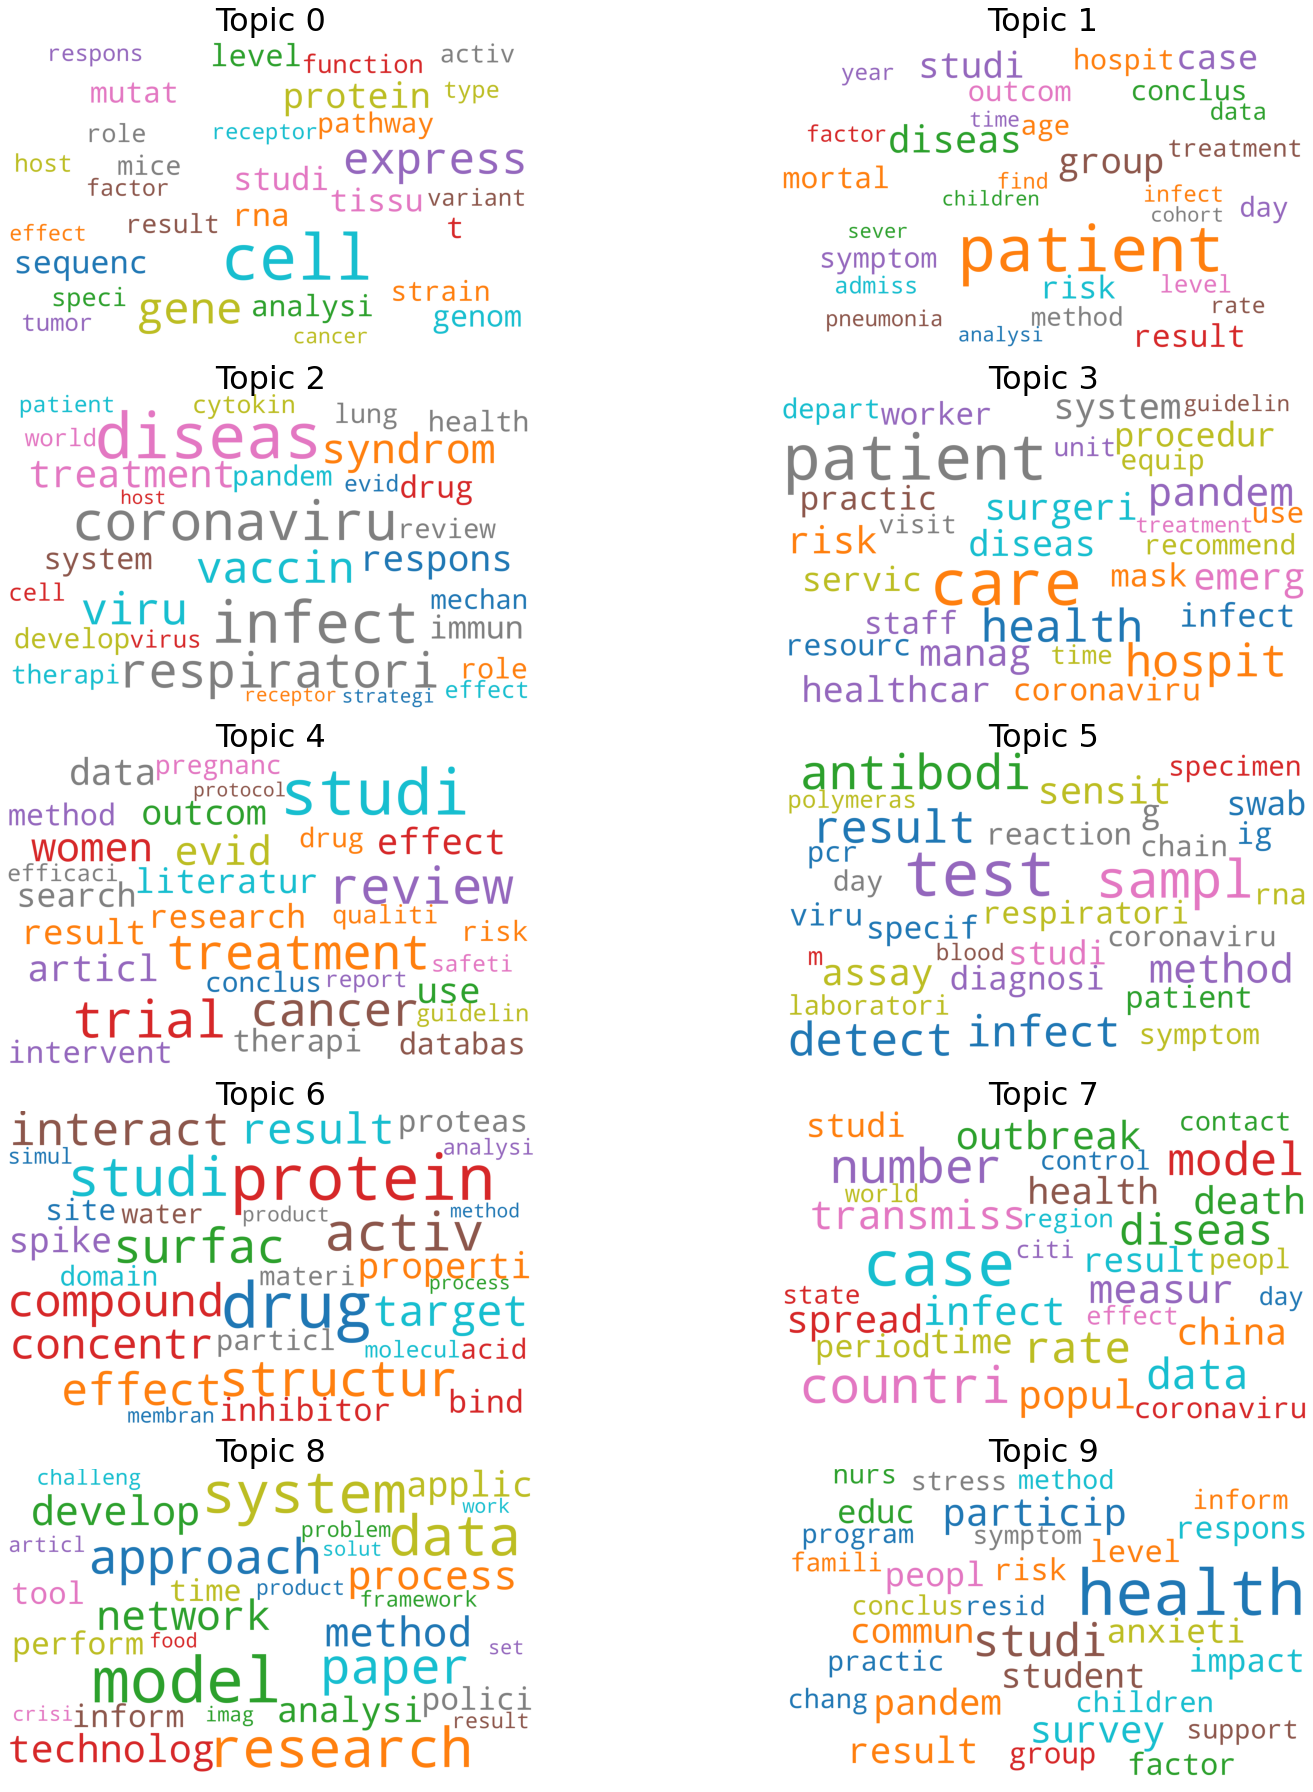

In [15]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(
                # stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1500,
                  # max_words=10,
                  colormap='tab10',
                  # color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0
                  )

topics = lda_model.show_topics(num_words=30, formatted=False)
fig, axes = plt.subplots(5, 2, figsize=(25,25), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=32))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Use pyLDAvis tool to perform visualization.

In [16]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.095146 -0.184751       1        1  17.814921
9     -0.127059  0.101178       2        1  13.374855
7     -0.110278 -0.034809       3        1  12.360494
8      0.003951  0.217670       4        1  11.127630
3     -0.198272  0.032742       5        1  10.780946
2     -0.007209 -0.044755       6        1  10.230296
4     -0.053054  0.117373       7        1   6.925524
6      0.250499  0.097251       8        1   6.325432
0      0.307491 -0.045283       9        1   6.259486
5      0.029079 -0.256616      10        1   4.800416, topic_info=           Term          Freq         Total Category  logprob  loglift
31      patient  73866.000000  73866.000000  Default  30.0000  30.0000
49         cell  13347.000000  13347.000000  Default  29.0000  29.0000
397        care  17719.000000  17719.000000  Default  28.0000  28.0000
105      infect  27134.000000  27134.000000  Default  27.0000  27.0000
103      diseas  36161.000000  36161.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
226         day   1319.201482   9674.221131  Topic10  -4.6552   1.0440
71        studi   1822.721770  36825.050236  Topic10  -4.3319   0.0306
164  coronaviru   1330.066452  21629.103768  Topic10  -4.6470   0.2477
31      patient   1538.800898  73866.042767  Topic10  -4.5012  -0.8348
266       blood    933.304720   3834.134913  Topic10  -5.0013   1.6235

[740 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
6167      9  0.995581        ab
576       1  0.961104    abnorm
576       9  0.038305    abnorm
6397      7  0.993964  abstract
1340      9  0.996531     abund
...     ...       ...       ...
99        3  0.170940      year
99        4  0.045823      year
99        6  0.038042      year
99        7  0.035571      year
99        8  0.001606      year

[1615 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 10, 8, 9, 4, 3, 5, 7, 1, 6])